## 보스턴 집값 예측 모델
- 데이터셋 : boston.csv
- 목적 : MEDV 예측  
- 피쳐 : 13개
- 타겟 : MEDV
- 학습방법 : 지도학습 > 회귀  
- 알고리즘 : 선형관계 - 선형모델 => nn.Linear
- 프레임워크 : Pytorch

CRIM: 도시의 범죄율  
ZN: 25,000 평방 피트 이상의 주택 비율  
INDUS: 비소매 상업 지역의 비율  
CHAS: 찰스 강 경계 여부 (1: 경계, 0: 경계 아님)  
NOX: 일산화질소 농도  
RM: 주택당 평균 방 개수  
AGE: 1940년 이전에 지어진 주택     
DIS: 5개의 보스턴 고용센터까지의 가중 거리  
RAD: 고속도로 접근성 지수  
TAX: 재산세율  
PTRATIO: 지역별 학생 대 교사 비율  
B: 흑인 비율(B = 1000(Bk - 0.63)^2, Bk는 흑인의 비율)  
LSTAT: 하위 계층 비율  
MEDV: 주택 가격(중앙값)  

[1] 모듈로딩

In [168]:
import torch                    #텐서 및 수치 계산 함수 관련모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F # 손길, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score
from torchinfo import summary
import pandas as pd         
from sklearn.model_selection import train_test_split    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[2] 데이터 준비

In [169]:
# 랜덤 시드 설정
torch.manual_seed(1)

DEVICE ='cuda' if torch.cuda.is_available() else 'cpu'

print(f"DEVICE => {DEVICE}")

DEVICE => cpu


In [170]:
# 데이터 로딩 csv => DataFrame
FILE_PATH = r'C:\baekjoon-solutions\연습\boston.csv'

df=pd.read_csv(FILE_PATH)
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


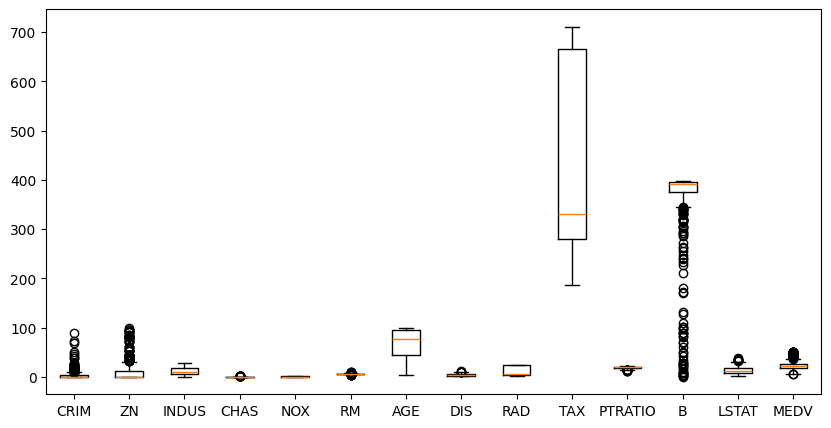

In [172]:
# 박스플롯
plt.figure(figsize = (10, 5))
plt.boxplot(df.iloc[:, :14])
plt.xticks(np.arange(1,15), df.columns[:14])
plt.show()

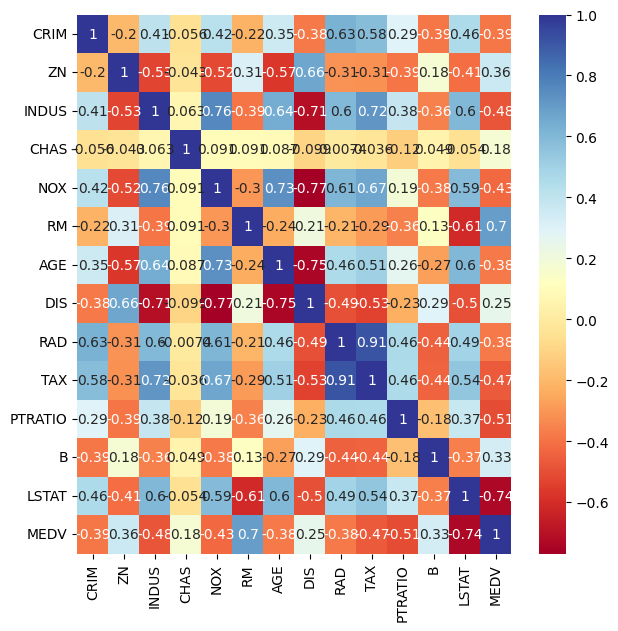

In [173]:
plt.figure(figsize=(7,7))
g = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='RdYlBu')
plt.show()

[3] 모델 준비

- 학습방법 : 지도학습 - 회귀
- 알고리즘 : 선형관계 - 선형모델 ==> nn.Linear

In [174]:
# in_features : CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX , PTRATIO, B	, LSTAT
# out_features : MEDV

model = nn.Sequential( nn.Linear(13,10),
                      nn.ReLU(),
                      nn.Linear(10,5),
                      nn.ReLU(),
                      nn.Linear(5,1))

In [175]:
# 모델 메모리 확인
print(model)
summary(model, input_size=(506,13))

Sequential(
  (0): Linear(in_features=13, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [506, 1]                  --
├─Linear: 1-1                            [506, 10]                 140
├─ReLU: 1-2                              [506, 10]                 --
├─Linear: 1-3                            [506, 5]                  55
├─ReLU: 1-4                              [506, 5]                  --
├─Linear: 1-5                            [506, 1]                  6
Total params: 201
Trainable params: 201
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.03
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [176]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  0.1302, -0.2611,  0.1663, -0.0571,  0.1411,
          0.0386, -0.0340,  0.0769,  0.0137,  0.1013],
        [-0.1081, -0.0202, -0.0250,  0.0402, -0.0011,  0.2425,  0.0863, -0.1033,
         -0.1675, -0.0465, -0.1196, -0.0889,  0.0133],
        [ 0.1653,  0.1507, -0.2711,  0.1719,  0.0775,  0.2631,  0.1831, -0.2527,
         -0.2637, -0.1338,  0.2435, -0.0462,  0.1187],
        [-0.1289,  0.2721, -0.1173,  0.2080,  0.0033, -0.1461,  0.1426, -0.1472,
          0.0816, -0.0801, -0.0304, -0.2666, -0.1322],
        [ 0.1505, -0.0674,  0.2763,  0.2223, -0.0130, -0.1851,  0.1689,  0.0861,
         -0.1793,  0.1802,  0.1684,  0.2460, -0.1555],
        [-0.0457, -0.0054,  0.0405, -0.2105, -0.1968,  0.1509, -0.0650,  0.1355,
          0.0158,  0.0911,  0.0610,  0.1008,  0.1375],
        [-0.2569,  0.1396, -0.1950, -0.2093,  0.0169, -0.0473,  0.1629, -0.1606,
         -0.2466,  0.2018, -0.0411,  0.1560,  0.0892],
        [-0.208

[4] 최적화 인스턴스 준비

In [177]:
## 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[5] 학습 ==> 개발자가 구현

[5-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 학습 전 진행

In [178]:
featureDF=df[df.columns[:-1]]
targetDF=df[['MEDV']]

print(featureDF.shape, targetDF.shape)

(506, 13) (506, 1)


[5-2] 학습,검증, 테스트데이터셋 분리

In [179]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size=0.2, random_state=42)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'[Feature] Train {X_train.shape}, TEST { X_test.shape}, VAL {X_val.shape}')
print(f'[Target] Train {y_train.shape}, TEST { y_test.shape}, VAL {y_val.shape}')

[Feature] Train (323, 13), TEST (102, 13), VAL (81, 13)
[Target] Train (323, 1), TEST (102, 1), VAL (81, 1)


[5-3] 스탠다드 스케일러

In [180]:
from sklearn.preprocessing import StandardScaler

In [181]:
scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [182]:
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

[5-3] 학습 진행
- 에포크 => 학습횟수
- loss => 학습결과(손실저장)

In [183]:
EPOCH=100
BATCH_SIZE=10
BATCH_CNT = X_train.shape[0]//BATCH_SIZE

print(f'EPOCH:{EPOCH}, BATCH_SIZE:{BATCH_SIZE}, BATCH_CNT:{BATCH_CNT}')

EPOCH:100, BATCH_SIZE:10, BATCH_CNT:32


In [184]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
# 모델 학습 함수
def testing(testDF,targetDF, kind='Val'):
    # Tensor화
    testTS=torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS=torch.FloatTensor(targetDF.values).to(DEVICE)
    with torch.no_grad():    # 가중치 및 절편 업데이트 진행 X
        #-(1)학습진행 - forward
        pre_y=model(testTS)
        #-(2)오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)

        #-(3)성능평가 - R2
        r2 = R2Score()(pre_y, targetTS)
 
        #-(4)학습결과 출력 및 저장
        #print(f'[{kind}] LOSS: {loss}, R2 : {r2}')
    return loss, r2

In [185]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS, testTS, testtargetTS):

    loss_history=[[],[],[]] # [[트레인], [검증], [테스트]]
    r2_hisory =[[],[],[]] # [[트레인], [검증], [테스트]]

    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss, bs_r2 = 0,0
        # 배치 크기 만큼 학습 진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE  # 시작은 0,   11, 
            end = start + BATCH_SIZE
            # BS 크기만큼만의 데이터를 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(DEVICE) # 배치의 트레인 피쳐
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(DEVICE) # 배치의 트레인 정답


            #-(1)학습진행 - forward
            pre_y=model(BSX_train)
            #-(2)오차계산 - 손실함수
            loss=F.mse_loss(pre_y, BSy_train)
            bs_loss += loss.item()      # 각횟수다 로스 추가
            r2 =R2Score()(pre_y, BSy_train)
            bs_r2 += r2.item()
        
            #-(3)최적화 - 가중치,절편 업데이트 backward
            adam_optim.zero_grad() #gradient를 0으로 초기화
            loss.backward() #  오차 미분, 비용 함수를 미분하여 gradient 계산
            adam_optim.step() #  가중치 업데이트 W와 b를 업데이트

        #-(4)검증 - 모댈이 제대로 만들어지는 검사용
        val_loss, val_r2 = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_hisory[1].append(val_r2.item())
        
        # (5) 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT) # 평균을 추가
        r2_hisory[0].append(bs_r2/BATCH_CNT)   # 평균을 추가

        #-(5)테스트 - 테스트 결과 저장
        test_loss, test_r2 = testing(testTS, testtargetTS)
        loss_history[2].append(test_loss.item())
        r2_hisory[2].append(test_r2.item())

        #-(6)학습결과 출력 및 저장
        print(f'[{epoch}//{EPOCH}]\n Train LOSS: {loss_history[0][-1]} R2 : {r2_hisory[0][-1]}')
        print(f'-VALID LOSS: {loss_history[1][-1]} R2 : {r2_hisory[1][-1]}')
        print(f'-TEST LOSS: {loss_history[2][-1]} R2 : {r2_hisory[2][-1]}')
    return loss_history, r2_hisory

In [186]:
# 모델 학습 진행
loss, r2 = training(X_train_scaled_df, y_train, X_val_scaled_df, y_val, X_test_scaled_df, y_test)

[0//100]
 Train LOSS: 695.4081158638 R2 : -8.67562347650528
-VALID LOSS: 482.6292419433594 R2 : -5.788055419921875
-TEST LOSS: 431.9032897949219 R2 : -4.889553546905518
[1//100]
 Train LOSS: 449.8208646774292 R2 : -5.65595405548811
-VALID LOSS: 380.2853088378906 R2 : -4.34861421585083
-TEST LOSS: 336.859375 R2 : -3.593508243560791
[2//100]
 Train LOSS: 356.82985496520996 R2 : -4.152656361460686
-VALID LOSS: 296.7238464355469 R2 : -3.173344135284424
-TEST LOSS: 260.2195739746094 R2 : -2.548426389694214
[3//100]
 Train LOSS: 282.6200613975525 R2 : -2.9661042504012585
-VALID LOSS: 231.4746551513672 R2 : -2.2556312084198
-TEST LOSS: 201.33563232421875 R2 : -1.7454686164855957
[4//100]
 Train LOSS: 225.5894672870636 R2 : -2.066375907510519
-VALID LOSS: 182.15989685058594 R2 : -1.5620319843292236
-TEST LOSS: 157.76101684570312 R2 : -1.151273250579834
[5//100]
 Train LOSS: 183.11034727096558 R2 : -1.407599326223135
-VALID LOSS: 145.9974365234375 R2 : -1.0534162521362305
-TEST LOSS: 126.687194

In [187]:
loss 

[[695.4081158638,
  449.8208646774292,
  356.82985496520996,
  282.6200613975525,
  225.5894672870636,
  183.11034727096558,
  152.41014581918716,
  130.8871432542801,
  116.2569232583046,
  106.618208527565,
  100.46418541669846,
  96.65552455186844,
  94.3693796992302,
  93.0371530354023,
  92.28236284852028,
  91.86581692099571,
  91.6412989795208,
  91.52272647619247,
  91.46112787723541,
  91.42952877283096,
  91.41348713636398,
  91.4054599404335,
  91.40158361196518,
  91.3998783826828,
  91.39935255050659,
  91.3994812965393,
  91.39998406171799,
  91.40071454644203,
  91.40157699584961,
  91.40251812338829,
  91.40350085496902,
  91.40451517701149,
  91.40554091334343,
  91.406564027071,
  91.40759053826332,
  91.40860998630524,
  91.40962335467339,
  91.41063305735588,
  91.41163295507431,
  91.41262263059616,
  91.41360002756119,
  91.41457408666611,
  91.41554093360901,
  91.41649770736694,
  91.41744378209114,
  91.41838052868843,
  91.41931003332138,
  91.42022830247879,


In [188]:
testing(X_test, y_test)

(tensor(75.0174), tensor(-0.0230))

Text(0.5, 1.0, 'r2')

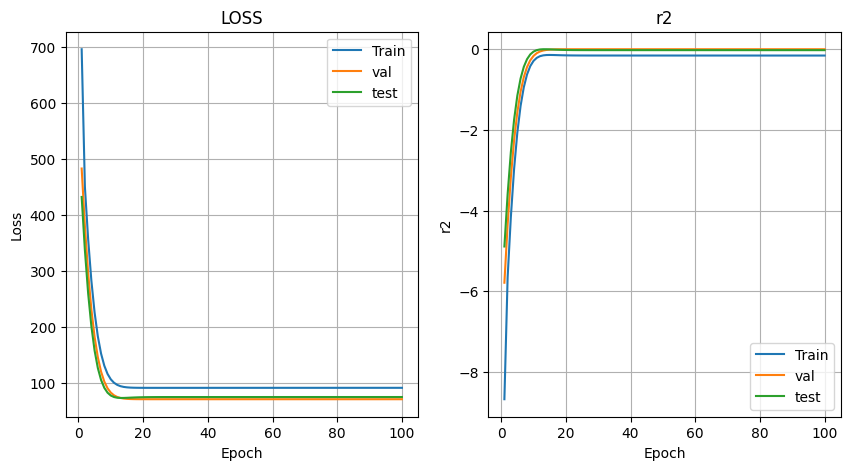

In [189]:
# 학습 후 loss 시각화
# 학습 후 loss 시각화


fg, axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].plot(range(1, EPOCH+1), loss[0], label='Train')
axes[0].plot(range(1, EPOCH+1), loss[1], label='val')
axes[0].plot(range(1, EPOCH+1), loss[2], label='test')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), r2[0], label='Train')
axes[1].plot(range(1, EPOCH+1), r2[1], label='val')
axes[1].plot(range(1, EPOCH+1), r2[2], label='test')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("r2")
axes[1].set_title("r2")
